## Overview

Given PCA coordinates generate a figure that captures the main structure identified.

In [1]:
import gcsfs
import zarr
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

In [2]:
import allel

In [3]:
from ag3 import release_data
v3 = release_data()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Data storage, uses about 34 MB
pca_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

import gcsfs
# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

In [5]:
pca_cloud_zarr_path = pca_cloud_zarr_path_template.format('gamb_colu')
pca_cloud_zarr_path

'vo_agam_production/ag3_data_paper/gamb_colu.pca_output.zarr'

In [6]:
# Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
# Keep the zarr_store for zarr.consolidate_metadata(zarr_store)
zarr_store = auth_fs.get_mapper(pca_cloud_zarr_path)
zarr_group = zarr.group(zarr_store)

In [7]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [8]:
sample_names = zarr_group["sample_names"][:]
sample_names = [s.decode() for s in sample_names]

In [9]:
pca_coordinates = zarr_group["coords"]
pca_components = zarr_group["components"]
pca_pve = zarr_group["explained_variance_ratio"]

In [10]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [11]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [12]:
all_meta.columns

Index(['partner_sample_id', 'contributor', 'country', 'location', 'year',
       'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'aim_fraction_colu', 'aim_fraction_arab', 'species_gambcolu_arabiensis',
       'species_gambiae_coluzzii', 'is_arabiensis', 'is_gamb_colu',
       'is_gambiae', 'is_coluzzii'],
      dtype='object')

In [13]:
df_species_samples = all_meta.loc[sample_names]
df_species_samples.head()

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [14]:
color_lookup = pd.DataFrame([(k, a, b)  for k, v in v3.location_colours.items() for a, b in v.items()], columns=["country", "location", "colorhex"])

In [15]:
df_species_samples = df_species_samples.merge(color_lookup, how="left")

In [16]:
components = np.arange(8, dtype=np.int8).reshape((2, 2, 2))
components

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]], dtype=int8)

In [17]:
import seaborn as sns

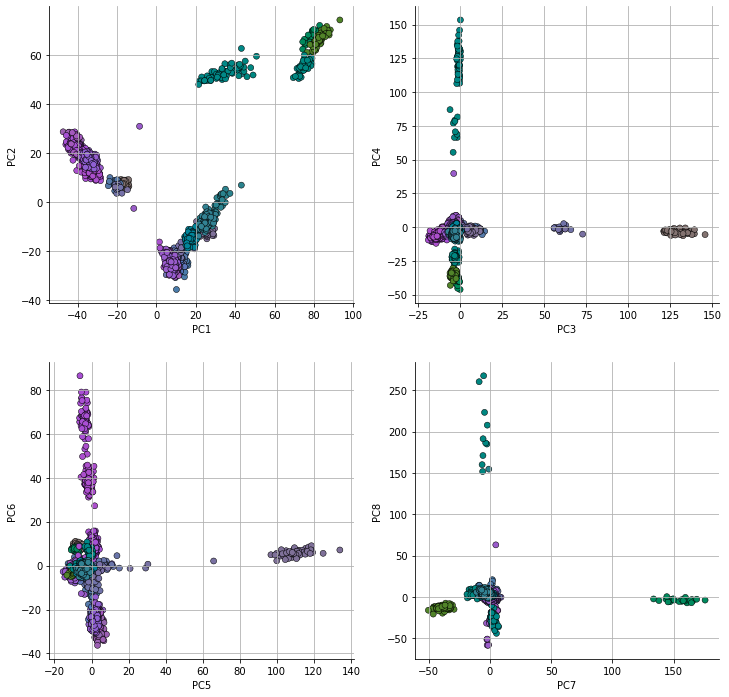

In [18]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))


for ix in range(2):
        
    for jx in range(2):
            
        component_a, component_b = components[ix][jx]
        ax = axes[ix, jx]

        ax.scatter(pca_coordinates[:, component_a], pca_coordinates[:, component_b], c=df_species_samples.colorhex, edgecolor='k', lw=0.5)
        ax.grid(True)
        ax.set_xlabel(f"PC{component_a + 1}")
        ax.set_ylabel(f"PC{component_b + 1}")
        sns.despine(ax=ax)

f.savefig("../content/images/pca/gamb_colu.svg", dpi=200)